In [2]:
import netgen.gui
from netgen.geom2d import unit_square
from ngsolve import *
import pandas as pd

### Initializations

In [3]:
## Parameter setup
orders = [1, 2, 3]
beta = (2,0.001)
mesh_size = [1.0, 0.5, 0.25, 0.1250, 0.0625, 0.0313]
eps = 0.01

# Exact Solution
p = lambda x: x + (exp(beta[0]*x/eps)-1)/(1-exp(beta[0]/eps))
q = lambda y: y + (exp(beta[1]*y/eps)-1)/(1-exp(beta[1]/eps))

exact = p(x) * q(y)
coeff =  beta[1] * p(x) +  beta[0] * q(y)

coeff_x = p(x)
coeff_y = q(y)

alpha = 10

### DG vs Enriched DG

#### Integration Order

In [5]:
columns = ['Order', 'Bonus Int', 'Mesh Size', 'Error']

##### DG

In [8]:
dg_val = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        fes = L2(mesh, order=order, dgjumps=True)
        u, v = fes.TnT()

        jump_u = u-u.Other()
        jump_v = v-v.Other()
        n = specialcf.normal(2)
        mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
        mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

        h = specialcf.mesh_size
        
        for val in range(1,20):
            # diffusion
            diffusion = grad(u) * grad(v) * dx(bonus_intorder = val) \
                +alpha * order ** 2/ h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
                +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
                +alpha * order ** 2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
                + (-n * grad(u) * v -n * grad(v) * u) * ds(skeleton=True, bonus_intorder = val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b * n, u, u.Other())
            convection = -b * u * grad(v) * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder=val)
            f.Assemble()

            gfu = GridFunction(fes, name="uDG")        
            gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            #Draw (gfu)

            error = sqrt (Integrate ((gfu-exact)*(gfu-exact), mesh))
            dg_val.loc[len(dg_val)] = [order, val, size, error]
        
        #Draw(gfu, mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' +"dg-h_"+str(size)+"-k_"+str(order)+".png")
        
        #print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)
    #print('......................................................................')
    
%store dg_val

Stored 'dg_val' (DataFrame)


##### Enriched DG

In [9]:
edg_val = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = 0.0001 * size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        for val in range(1,20):
            # diffusion
            diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
            + alpha * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
            + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
            + alpha * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
            + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b*n, u, u_Other)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder = val)
            f.Assemble()

            gfu = GridFunction(fes)
            try:
                gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
            edg_val.loc[len(edg_val)] = [order, val, size, error] 
            
            print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)
            
%store edg_val

Order: 1 Mesh Size: 1.0 L2-error: 0.01898468057747791
Order: 1 Mesh Size: 1.0 L2-error: 0.0012335617976425737
Order: 1 Mesh Size: 1.0 L2-error: 28.191604059695564
Order: 1 Mesh Size: 1.0 L2-error: 0.003883167910761303
Order: 1 Mesh Size: 1.0 L2-error: 0.003863210868055453
Order: 1 Mesh Size: 1.0 L2-error: 0.004327118500894596
Order: 1 Mesh Size: 1.0 L2-error: 0.004327118500894596
Order: 1 Mesh Size: 1.0 L2-error: 0.00887139375424198
Order: 1 Mesh Size: 1.0 L2-error: 0.00887139375424198
Order: 1 Mesh Size: 1.0 L2-error: 0.004351481676749668
Order: 1 Mesh Size: 1.0 L2-error: 0.004351481676749668
Order: 1 Mesh Size: 1.0 L2-error: 0.001351133034404474
Order: 1 Mesh Size: 1.0 L2-error: 0.001351133034404474
Order: 1 Mesh Size: 1.0 L2-error: 0.0011656810126103863
Order: 1 Mesh Size: 1.0 L2-error: 0.0011656810126103863
Order: 1 Mesh Size: 1.0 L2-error: 0.0011938813302361196
Order: 1 Mesh Size: 1.0 L2-error: 0.0011938813302361196
Order: 1 Mesh Size: 1.0 L2-error: 0.0012264817853786369
Order: 1 

Order: 2 Mesh Size: 0.5 L2-error: 0.0003215088532713005
Order: 2 Mesh Size: 0.5 L2-error: 0.0003215088532713005
Order: 2 Mesh Size: 0.5 L2-error: 0.00032372521711435007
Order: 2 Mesh Size: 0.5 L2-error: 0.00032372521711435007
Order: 2 Mesh Size: 0.5 L2-error: 0.0003249719866413284
Order: 2 Mesh Size: 0.5 L2-error: 0.0003249719866413284
Order: 2 Mesh Size: 0.25 L2-error: 0.0010207813440066833
Order: 2 Mesh Size: 0.25 L2-error: 0.0010015734081465343
Order: 2 Mesh Size: 0.25 L2-error: 0.0012036033545723987
Order: 2 Mesh Size: 0.25 L2-error: 0.0004450178604470188
Order: 2 Mesh Size: 0.25 L2-error: 0.0004450178604470188
Order: 2 Mesh Size: 0.25 L2-error: 0.00022548193495605515
Order: 2 Mesh Size: 0.25 L2-error: 0.00022548193495605515
Order: 2 Mesh Size: 0.25 L2-error: 0.00014493804647030696
Order: 2 Mesh Size: 0.25 L2-error: 0.00014493804647030696
Order: 2 Mesh Size: 0.25 L2-error: 0.0001318878691543615
Order: 2 Mesh Size: 0.25 L2-error: 0.0001318878691543615
Order: 2 Mesh Size: 0.25 L2-err

Order: 3 Mesh Size: 0.125 L2-error: 0.014018114589093866
Order: 3 Mesh Size: 0.125 L2-error: 4.3014775679367375e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.3014775679367375e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.264555598179965e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.264555598179965e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.293453980136426e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.293453980136426e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.3428777541476197e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.3428777541476197e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.303760512031169e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.303760512031169e-05
Order: 3 Mesh Size: 0.125 L2-error: 0.007172781973381347
Order: 3 Mesh Size: 0.125 L2-error: 0.007172781973381347
Order: 3 Mesh Size: 0.125 L2-error: 4.268085686571361e-05
Order: 3 Mesh Size: 0.125 L2-error: 4.268085686571361e-05
Order: 3 Mesh Size: 0.0625 L2-error: 0.0005435902976107131
Order: 3 Mesh Size: 0.0625 L2-error: 7.488381616856092e-06
Order: 3 Me

#### Alpha

In [10]:
columns = ['Order', 'Alpha', 'Mesh_Size', 'Error']
val = 15 # bonusintorder

##### DG

In [11]:
dg_alpha = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        fes = L2(mesh, order=order, dgjumps=True)
        u, v = fes.TnT()

        jump_u = u-u.Other()
        jump_v = v-v.Other()
        n = specialcf.normal(2)
        mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
        mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

        h = specialcf.mesh_size

        # diffusion
        for alp in range(1, 100):
            diffusion = grad(u) * grad(v) * dx(bonus_intorder=val) \
                +alp * order ** 2/ h * jump_u * jump_v * dx(skeleton=True, bonus_intorder=val) \
                +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder=val) \
                +alp * order ** 2/h * u * v * ds(skeleton=True, bonus_intorder=val) \
                + (-n * grad(u) * v -n * grad(v) * u) * ds(skeleton=True, bonus_intorder=val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b * n, u, u.Other())
            convection = -b * u * grad(v) * dx(bonus_intorder=val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder=val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder=val)
            f.Assemble()

            gfu = GridFunction(fes, name="uDG")
            try:
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            #gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            #Draw (gfu)

            error = sqrt (Integrate ((gfu-exact)*(gfu-exact), mesh))
            dg_alpha.loc[len(dg_alpha)] = [order, alp, size, error] 
            
%store dg_alpha

Stored 'dg_alpha' (DataFrame)


##### Enriched DG

In [12]:
edg_alpha = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        eps_size = 0.0001 * size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=0)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        for alp in range(1, 100):     
            # diffusion
            diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
            + alp * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
            + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
            + alp * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
            + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)

            # convection
            b = CoefficientFunction((beta[0],beta[1]) )
            uup = IfPos(b*n, u, u_Other)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
            convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection
            acd.Assemble()

            # rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder = val)
            f.Assemble()

            gfu = GridFunction(fes)
            try:
                gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(inverse="sparsecholesky") * f.vec
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
            edg_alpha.loc[len(edg_alpha)] = [order, alp, size, error] 
            #print('alpha', alp)
        #print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    #print('.......................................................................')
        
#Draw (gfu.components[2] * coeff_y, mesh, 'test')
%store edg_alpha

Stored 'edg_alpha' (DataFrame)


### HDG vs Enriched HDG

#### Integration Order

In [13]:
columns = ['Order', 'Bonus Int', 'Mesh Size', 'Error']

##### HDG

In [14]:
hdg_val = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top")

        fes = FESpace([V,F])
        u,uhat = fes.TrialFunction()
        v,vhat = fes.TestFunction()

        jump_u = u-uhat
        jump_v = v-vhat

        condense = True
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)
        
        for val in range(1,20):

            dS = dx(element_boundary=True, bonus_intorder=val)

            # diffusion
            diffusion = grad(u) * grad(v) * dx(bonus_intorder=val) + \
                alpha * order ** 2/h * jump_u * jump_v * dS + \
                (-grad(u) * n * jump_v - grad(v) * n * jump_u) * dS

            # convection            
            b = CoefficientFunction((beta[0],beta[1])) 
            uup = IfPos(b * n, u, uhat)
            convection = -b * u * grad(v) * dx(bonus_intorder=val) + b * n * uup * jump_v * dS

            acd = BilinearForm(fes, condense=condense)
            acd += eps * diffusion + convection
            acd.Assemble()

            #rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder=val)
            f.Assemble()

            gfu = GridFunction(fes)    
            if not condense:
                inv = acd.mat.Inverse(fes.FreeDofs(), "umfpack")
                gfu.vec.data = inv * f.vec
            else:
                f.vec.data += acd.harmonic_extension_trans * f.vec

                inv = acd.mat.Inverse(fes.FreeDofs(True), "umfpack")
                gfu.vec.data = inv * f.vec

                gfu.vec.data += acd.harmonic_extension * gfu.vec
                gfu.vec.data += acd.inner_solve * f.vec

            error = sqrt (Integrate ((gfu.components[0] - exact)*(gfu.components[0]- exact), mesh))
            hdg_val.loc[len(hdg_val)] = [order, val, size, error]
            
%store hdg_val

Stored 'hdg_val' (DataFrame)


##### Enriched HDG

In [17]:
ehdg_val = pd.DataFrame(columns=columns)
for order in orders:
    for size in mesh_size:        
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        Q = L2(mesh, order=0)
        QF = FacetFESpace(mesh, order=0)
        
        eps_size = 0.0001*size
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        
        gfF = GridFunction(QF)
        
        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_x[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_x = BitArray(QF.ndof)
        ba_F_x.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_x[i] = True

        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_y[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_y = BitArray(QF.ndof)
        ba_F_y.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_y[i] = True
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        QFx = Compress(QF, active_dofs=ba_F_x)
        QFy = Compress(QF, active_dofs=ba_F_y)
        
        F = FacetFESpace(mesh, order=order, dirichlet=".*")
        fes = FESpace([V, Qx, Qy, F, QFx, QFy])

        (us, px, py, uhat, uhatx, uhaty), (vs, qx, qy, vhat, vhatx, vhaty) = fes.TnT()
        
        #coeff=exact
        p = (coeff_x * px) + (coeff_y * py) 
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        vhat = vhat + vhatx * coeff_x + vhaty * coeff_y
        uhat = uhat + uhatx * coeff_x + uhaty * coeff_y
        
        jump_u = u-uhat
        jump_v = v-vhat
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        #condense = True
        
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)
        
        for val in range(1,20):
            dS = dx(element_boundary=True, bonus_intorder=val)

            diffusion = grad_u * grad_v *dx(bonus_intorder=val) + \
                alpha * order**2/h*jump_u*jump_v*dS + \
                (-grad_u *n*jump_v - grad_v *n*jump_u)*dS

            b = CoefficientFunction((beta[0],beta[1]))
            uup = IfPos(b * n, u, uhat)
            convection = -b * u * grad_v *dx(bonus_intorder=val) + b * n * uup * jump_v * dS

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection

            with TaskManager():
                acd.Assemble()
            f = LinearForm(fes)
            f += SymbolicLFI(coeff*v,bonus_intorder=val)

            with TaskManager():
                f.Assemble()

            gfu = GridFunction(fes)
            ## umfpack gives weird values
            try:
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            except:
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="sparsecholesky") * f.vec
                
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh, order=15))
            ehdg_val.loc[len(ehdg_val)] = [order, val, size, error] 

%store ehdg_val    

Stored 'ehdg_val' (DataFrame)


#### Alpha

##### HDG

In [18]:
hdg_alpha = pd.DataFrame(columns=columns)
val = 15
for order in orders:
    for size in mesh_size:
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        F = FacetFESpace(mesh, order=order, dirichlet="bottom|left|right|top")

        fes = FESpace([V,F])
        u,uhat = fes.TrialFunction()
        v,vhat = fes.TestFunction()

        jump_u = u-uhat
        jump_v = v-vhat

        condense = True
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)

        dS = dx(element_boundary=True, bonus_intorder=val)

        # diffusion
        for alpha in range(1,100):
            diffusion = grad(u) * grad(v) * dx(bonus_intorder=val) + \
                alpha * order ** 2/h * jump_u * jump_v * dS + \
                (-grad(u) * n * jump_v - grad(v) * n * jump_u) * dS

            # convection            
            b = CoefficientFunction((beta[0],beta[1])) 
            uup = IfPos(b * n, u, uhat)
            convection = -b * u * grad(v) * dx(bonus_intorder=val) + b * n * uup * jump_v * dS

            acd = BilinearForm(fes, condense=condense)
            acd += eps * diffusion + convection
            acd.Assemble()

            #rhs
            f = LinearForm(fes)
            f += SymbolicLFI(coeff * v, bonus_intorder=val)
            f.Assemble()

            gfu = GridFunction(fes)    
            if not condense:
                inv = acd.mat.Inverse(fes.FreeDofs(), "umfpack")
                gfu.vec.data = inv * f.vec
            else:
                f.vec.data += acd.harmonic_extension_trans * f.vec

                inv = acd.mat.Inverse(fes.FreeDofs(True), "umfpack")
                gfu.vec.data = inv * f.vec

                gfu.vec.data += acd.harmonic_extension * gfu.vec
                gfu.vec.data += acd.inner_solve * f.vec

            error = sqrt (Integrate ((gfu.components[0] - exact)*(gfu.components[0]- exact), mesh))
            hdg_alpha.loc[len(hdg_alpha)] = [order, alpha, size, error]
            
%store hdg_alpha

Stored 'hdg_alpha' (DataFrame)


##### Enriched HDG

In [19]:
ehdg_alpha = pd.DataFrame(columns=columns)
val = 15
for order in orders:
    for size in mesh_size:        
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        Q = L2(mesh, order=0)
        QF = FacetFESpace(mesh, order=0)
        
        eps_size = 0.0001*size
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        
        gfF = GridFunction(QF)
        
        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_x[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_x = BitArray(QF.ndof)
        ba_F_x.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_x[i] = True

        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_y[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_y = BitArray(QF.ndof)
        ba_F_y.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_y[i] = True
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        QFx = Compress(QF, active_dofs=ba_F_x)
        QFy = Compress(QF, active_dofs=ba_F_y)
        
        #print(Qx.ndof,Qy.ndof,QFx.ndof,QFy.ndof)
        # Facets. Here the jumps aren't necessary. 
        F = FacetFESpace(mesh, order=order, dirichlet=".*")
        fes = FESpace([V, Qx, Qy, F, QFx, QFy])
        #print(fes.FreeDofs())

        (us, px, py, uhat, uhatx, uhaty), (vs, qx, qy, vhat, vhatx, vhaty) = fes.TnT()
        
        #coeff=exact
        p = (coeff_x * px) + (coeff_y * py) 
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        vhat = vhat + vhatx * coeff_x + vhaty * coeff_y
        uhat = uhat + uhatx * coeff_x + uhaty * coeff_y
        #vhat = vhat + vhatx * sin(x) + vhaty * sin(y)
        #uhat = uhat + uhatx * sin(x) + uhaty * sin(y)
        
        jump_u = u-uhat
        jump_v = v-vhat
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        #condense = True
        
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)
        dS = dx(element_boundary=True, bonus_intorder=val)
        
        for alpha in range(1,100):                
            diffusion = grad_u * grad_v *dx(bonus_intorder=val) + \
                alpha * order**2/h*jump_u*jump_v*dS + \
                (-grad_u *n*jump_v - grad_v *n*jump_u)*dS

            b = CoefficientFunction((beta[0],beta[1]))
            uup = IfPos(b * n, u, uhat)
            convection = -b * u * grad_v *dx(bonus_intorder=val) + b * n * uup * jump_v * dS

            acd = BilinearForm(fes)
            acd += eps * diffusion + convection

            with TaskManager():
                acd.Assemble()
            
            f = LinearForm(fes)
            f += SymbolicLFI(coeff*v,bonus_intorder=val)

            with TaskManager():
                f.Assemble()

            gfu = GridFunction(fes)
            gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
            u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y

            error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh, order=15))
            ehdg_alpha.loc[len(ehdg_alpha)] = [order, alpha, size, error]
        

%store ehdg_alpha

Stored 'ehdg_alpha' (DataFrame)


### Others

In [6]:
columns = ['Order', 'Mesh Size', 'Error']
edg_order = pd.DataFrame(columns=columns)
val = 15 # bonusintorder
for order in orders:
    for size in mesh_size:
        eps_size = 0.0001*size
        #eps = 1e-8
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order, dgjumps=True)
        Q = L2(mesh, order=order)
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        
        fes = FESpace([V, Qx, Qy], dgjumps = True)

        (us, px, py), (vs, qx, qy) = fes.TnT()
        
        #coeff=exact
        ## Enrichment
        p = (coeff_x * px) + (coeff_y * py)
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        u_Other = us.Other() + coeff_x * px.Other() + coeff_y * py.Other()
        v_Other = vs.Other() + coeff_x * qx.Other() + coeff_y * qy.Other()
        
        jump_u = u - u_Other
        jump_v = v - v_Other
        
        n = specialcf.normal(2)
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        grad_uOther = grad(us.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py.Other() \
        + coeff_x * grad(px.Other()) + coeff_y * grad(py.Other())
        
        grad_vOther = grad(vs.Other()) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx.Other() \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy.Other() \
        + coeff_x * grad(qx.Other()) + coeff_y * grad(qy.Other())
                
            
        mean_dudn = 0.5 * n * (grad_u + grad_uOther)
        mean_dvdn = 0.5 * n * (grad_v + grad_vOther)
        
        h = specialcf.mesh_size
        
        # diffusion
        diffusion = grad_u * grad_v * dx(bonus_intorder = val) \
        + alpha * order**2/h * jump_u * jump_v * dx(skeleton=True, bonus_intorder = val) \
        + (-mean_dudn* jump_v - mean_dvdn * jump_u) * dx(skeleton=True, bonus_intorder = val) \
        + alpha * order**2/h * u * v * ds(skeleton=True, bonus_intorder = val) \
        + (-n * grad_u * v - n * grad_v * u) * ds(skeleton=True, bonus_intorder = val)
                
        # convection
        b = CoefficientFunction((beta[0],beta[1]) )
        uup = IfPos(b*n, u, u_Other)
        convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * jump_v * dx(skeleton=True, bonus_intorder = val)
        convection = -b * u * grad_v * dx(bonus_intorder = val) + b * n * uup * v * dx(element_boundary=True, bonus_intorder = val)
       
        acd = BilinearForm(fes)
        acd += eps * diffusion + convection
        
        with TaskManager():
            acd.Assemble()

        # rhs
        f = LinearForm(fes)
        f += SymbolicLFI(coeff * v, bonus_intorder = val)
        
        with TaskManager():
            f.Assemble()

        gfu = GridFunction(fes)
        gfu.vec.data = acd.mat.Inverse(inverse="umfpack") * f.vec
    
        u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh))
        edg_order.loc[len(edg_order)] = [order, size, error]
        
        #Draw(u2,mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "edg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('.......................................................................')
        
#Draw (gfu.components[2] * coeff_y, mesh, 'test')
%store edg_order

Order: 1  Mesh Size: 1.0 L2 Error: 0.0002859454325535549
Order: 1  Mesh Size: 0.5 L2 Error: 0.0004174206134124518
Order: 1  Mesh Size: 0.25 L2 Error: 0.0001160722063488964
Order: 1  Mesh Size: 0.125 L2 Error: 3.109537480457185e-05
Order: 1  Mesh Size: 0.0625 L2 Error: 0.0012012840283591815
Order: 1  Mesh Size: 0.0313 L2 Error: 0.0008961811128677633
.......................................................................
Order: 2  Mesh Size: 1.0 L2 Error: 0.004468853712665372
Order: 2  Mesh Size: 0.5 L2 Error: 0.00030245180903363985
Order: 2  Mesh Size: 0.25 L2 Error: 1.9727357892770368e-05
Order: 2  Mesh Size: 0.125 L2 Error: 1.2662427425326445e-06
Order: 2  Mesh Size: 0.0625 L2 Error: 1.2316470202679725e-07
Order: 2  Mesh Size: 0.0313 L2 Error: 6.252022824754548e-07
.......................................................................
Order: 3  Mesh Size: 1.0 L2 Error: 0.004586037967387188
Order: 3  Mesh Size: 0.5 L2 Error: 0.0010864809858687984
Order: 3  Mesh Size: 0.25 L2 Error: 1.

In [10]:
ehdg_order = pd.DataFrame(columns=columns)
val = 15
for order in orders:
    for size in mesh_size:        
        mesh = Mesh(unit_square.GenerateMesh(maxh=size))
        V = L2(mesh, order=order)
        Q = L2(mesh, order=order)
        QF = FacetFESpace(mesh, order=0)
        
        eps_size = 0.0001*size
        
        ba_x = BitArray(Q.ndof)        
        ba_x.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[0] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_x[dof] = mark
        
        ba_y = BitArray(Q.ndof)
        ba_y.Clear()
        
        for el in Q.Elements():
            mark = False
            for v in el.vertices:
                if (mesh[v].point[1] > 1-eps_size):
                    mark = True
            for dof in el.dofs:
                ba_y[dof] = mark
        
        
        gfF = GridFunction(QF)
        
        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_x[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_x = BitArray(QF.ndof)
        ba_F_x.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_x[i] = True

        gfF.vec[:] = 0
        for el in QF.Elements():
            if ba_y[el.nr]:
                for dof in el.dofs:
                    gfF.vec[dof] += 1
        ba_F_y = BitArray(QF.ndof)
        ba_F_y.Clear()
        for i in range(QF.ndof):
            if gfF.vec[i] > 1.5:
                ba_F_y[i] = True
        
        Qx = Compress(Q, active_dofs=ba_x)
        Qy = Compress(Q, active_dofs=ba_y)
        QFx = Compress(QF, active_dofs=ba_F_x)
        QFy = Compress(QF, active_dofs=ba_F_y)
        
        #print(Qx.ndof,Qy.ndof,QFx.ndof,QFy.ndof)
        # Facets. Here the jumps aren't necessary. 
        F = FacetFESpace(mesh, order=order, dirichlet=".*")
        fes = FESpace([V, Qx, Qy, F, QFx, QFy])
        #print(fes.FreeDofs())

        (us, px, py, uhat, uhatx, uhaty), (vs, qx, qy, vhat, vhatx, vhaty) = fes.TnT()
        
        #coeff=exact
        p = (coeff_x * px) + (coeff_y * py) 
        q = (coeff_x * qx) + (coeff_y * qy)

        u = us + p
        v = vs + q
        
        vhat = vhat + vhatx * coeff_x + vhaty * coeff_y
        uhat = uhat + uhatx * coeff_x + uhaty * coeff_y
        #vhat = vhat + vhatx * sin(x) + vhaty * sin(y)
        #uhat = uhat + uhatx * sin(x) + uhaty * sin(y)
        
        jump_u = u-uhat
        jump_v = v-vhat
        
        grad_u = grad(us) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * px \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * py \
        + coeff_x * grad(px) + coeff_y * grad(py)
        
        grad_v = grad(vs) \
        + CoefficientFunction((coeff_x.Diff(x), coeff_x.Diff(y))) * qx \
        + CoefficientFunction((coeff_y.Diff(x), coeff_y.Diff(y))) * qy \
        + coeff_x * grad(qx) + coeff_y * grad(qy)
        
        #condense = True
        
        h = specialcf.mesh_size
        n = specialcf.normal(mesh.dim)
        dS = dx(element_boundary=True, bonus_intorder=val)
                
        diffusion = grad_u * grad_v *dx(bonus_intorder=val) + \
            alpha * order**2/h*jump_u*jump_v*dS + \
            (-grad_u *n*jump_v - grad_v *n*jump_u)*dS
        
        b = CoefficientFunction((beta[0],beta[1]))
        uup = IfPos(b * n, u, uhat)
        convection = -b * u * grad_v *dx(bonus_intorder=val) + b * n * uup * jump_v * dS

        acd = BilinearForm(fes)
        acd += eps * diffusion + convection
        
        with TaskManager():
            acd.Assemble()
        #print(acd.mat)
        f = LinearForm(fes)
        f += SymbolicLFI(coeff*v,bonus_intorder=val)
        
        with TaskManager():
            f.Assemble()

        gfu = GridFunction(fes)
        ## umfpack gives weird values
        gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
        u2 = gfu.components[0] + gfu.components[1] * coeff_x + gfu.components[2] * coeff_y
        
        error = sqrt (Integrate ((u2 - exact)*(u2- exact), mesh, order=15))
        ehdg_order.loc[len(ehdg_order)] = [order, size, error] 
        
        #Draw(u2,mesh,"u",sd=5)
        #netgen.gui.Snapshot(w=800,h=500, filename='Images/' + "ehdg-h_"+str(size)+"-k_"+str(order)+".png")
        
        print('Order:', order, ' Mesh Size:', size , "L2 Error:", error)
    print('.......................................................................')

%store ehdg_order    

Order: 1  Mesh Size: 1.0 L2 Error: 0.0005507551848948512
Order: 1  Mesh Size: 0.5 L2 Error: 0.0003457226397187999
Order: 1  Mesh Size: 0.25 L2 Error: 0.00011508022371375411
Order: 1  Mesh Size: 0.125 L2 Error: 3.0327504440418486e-05
Order: 1  Mesh Size: 0.0625 L2 Error: 8.11109319909635e-06
Order: 1  Mesh Size: 0.0313 L2 Error: 0.00034744468789804677
.......................................................................
Order: 2  Mesh Size: 1.0 L2 Error: 0.0007535721638835713
Order: 2  Mesh Size: 0.5 L2 Error: 0.00033489128681742086
Order: 2  Mesh Size: 0.25 L2 Error: 1.7806999725480485e-05
Order: 2  Mesh Size: 0.125 L2 Error: 1.287370923974404e-06
Order: 2  Mesh Size: 0.0625 L2 Error: 7.899312301856605e-07
Order: 2  Mesh Size: 0.0313 L2 Error: 5.253746181435682e-07
.......................................................................
Order: 3  Mesh Size: 1.0 L2 Error: 0.006383618381954573
Order: 3  Mesh Size: 0.5 L2 Error: 0.0007411286276782443
Order: 3  Mesh Size: 0.25 L2 Error: 1

In [20]:
eps = 0.01
val = []
import numpy as np
import matplotlib.pyplot as plt
r = lambda x: x - (exp(-(1-x)/ eps) - exp(-1 / eps)) / (1-exp(-1/eps))
for x in np.linspace(0,1,22):
    val.append(r(x))
    
plt.plot(np.linspace(0,1,22), val, '-b', label='Exact solution u(x)')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

<Figure size 640x480 with 1 Axes>

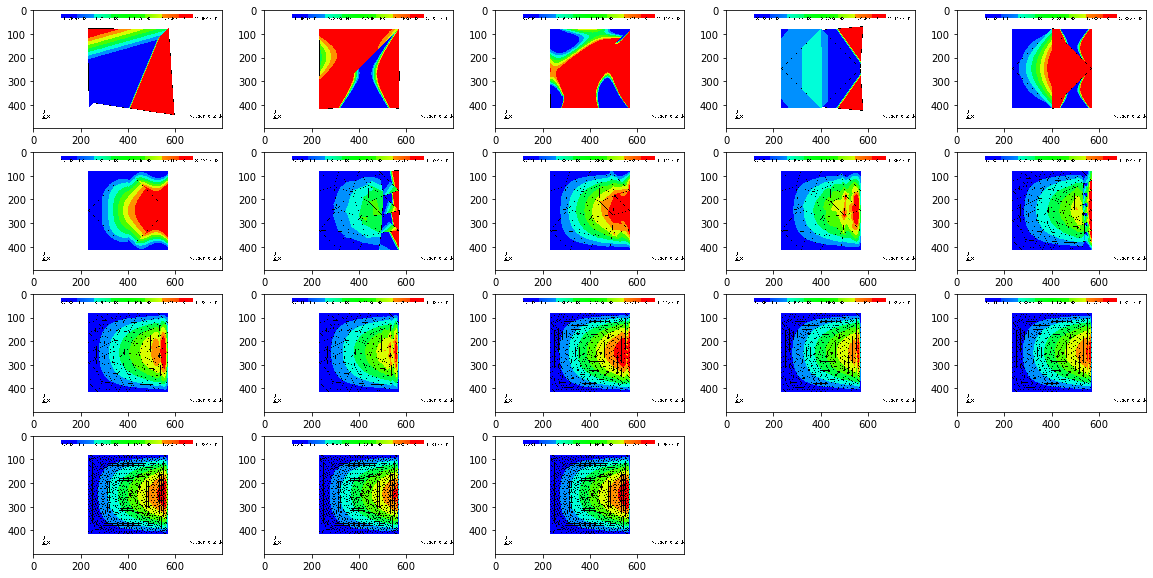

In [23]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

mesh_size = [1.0, 0.5, 0.25, 0.1250, 0.0625, 0.0313]
orders = [1, 2, 3]
plt.figure(figsize=(20,10))
columns = 5
listOfImageNames = ['Images/' + "dg-h_"+str(size)+"-k_"+str(order)+".png" for size in mesh_size for order in orders]


for i, imageName in enumerate(listOfImageNames):
    plt.subplot(len(listOfImageNames) / columns + 1, columns, i + 1)
    img= mpimg.imread(imageName)
    plt.imshow(img)